In [1]:
import os 
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import h5py
import numpy as np 


from scipy.integrate import simps
from scipy.optimize import curve_fit
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.lines import Line2D

sns.set_context("talk")

%matplotlib inline

In [2]:


# Fit the resolution data to a polynomial for extrapolation
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Create a function to get resolution for any energy
def get_resolution(e,popt):
    return np.maximum(poly_func(e, *popt), 1e-10)  # Ensure non-zero resolution


# Perform Gaussian broadening using convolution with energy-dependent widths
def gaussian_broadening(dos, energy, sigmas):
    broadened_dos = np.zeros_like(dos)
    for i in range(len(energy)):
        # Create a Gaussian kernel centered at each energy point with width sigmas[i]
        kernel = np.exp(-0.5 * ((energy - energy[i]) / sigmas[i])**2)
        kernel /= simps(kernel, energy)  # Normalize the kernel to preserve area
        broadened_dos += dos[i] * kernel  # Convolve DOS with Gaussian kernel
    return broadened_dos

def apply_gaussian_broadening(dos_data,metric='dos total (nm2/ps)',unit_cell_atoms=1):
    energy = dos_data['Energy Transfer (meV)'].values
    dos = dos_data[metric].values

    resolution_data = pd.read_csv('../data/experiment/resolution.csv')
    res_energy = resolution_data['Energy (meV)'].values
    resolution = resolution_data['Resolution'].values
    popt, _ = curve_fit(poly_func, res_energy, resolution)
    
    # Create an array of sigmas for Gaussian broadening based on the resolution function
    sigmas = get_resolution(energy,popt) / np.sqrt(8 * np.log(2))  # Convert FWHM to sigma


    broadened_dos = gaussian_broadening(dos, energy, sigmas)

    # Area normalize both original and broadened DOS
    original_area = simps(dos, energy)
    broadened_area = simps(broadened_dos, energy)

    dos_normalized = dos / original_area
    broadened_dos_normalized = broadened_dos / broadened_area
    return 3*unit_cell_atoms*broadened_dos_normalized


def read_lammps_dos(filename,min_energy,max_energy):
        h5file=h5py.File(filename)
        data_dict=dict()
        omega_shape=h5file["omega"][:].shape
        for k in h5file.keys():
            data_array=h5file[k][:]
            if data_array.shape != omega_shape or "_0" in k:
                continue
            units=h5file[k].attrs['units']
            data_dict["%s (%s)"%(k.replace("_"," "),units)]=data_array
        df_tmp=pd.DataFrame(data_dict).query("%f < `omega (rad/ps)` and `omega (rad/ps)` < %f"%(min_energy/0.6582,max_energy/0.6582))
        df_tmp["Energy Transfer (meV)"]=df_tmp["omega (rad/ps)"]*0.6582
        df_tmp["Normalized Count"]=apply_gaussian_broadening(df_tmp,unit_cell_atoms=137)
        for species,unit_cell_atoms in {"Fe":105-32,"O":32}.items():
            df_tmp[species]=apply_gaussian_broadening(df_tmp,"dos %s (nm2/ps)"%species,unit_cell_atoms)
            df_tmp["Max Normalized %s"%species]=df_tmp[species]/df_tmp[species].max()
        df_tmp["Max Normalized Count"]=df_tmp["Normalized Count"]/df_tmp["Normalized Count"].max()
        return df_tmp

In [3]:
experimental_data={"../data/experiment/xray.csv":"X-Ray"
                  ,"../data/experiment/TOF_INS.csv":"TOF-INS"
          }
df_list=list()
for filename,ref in experimental_data.items():
    df_tmp=pd.read_csv(filename)
    df_tmp["Normalized Count"]=3*137*df_tmp["Intensity"]/simps(df_tmp["Intensity"], df_tmp["Energy Transfer (meV)"])
    df_tmp["Max Normalized Count"]=df_tmp["Intensity"]/df_tmp["Intensity"].max()
    df_tmp["Reference"]=ref
    df_list.append(df_tmp)
    
df_experiment=pd.concat(df_list,ignore_index=True)

<Axes: xlabel='Energy Transfer (meV)', ylabel='Max Normalized Count'>

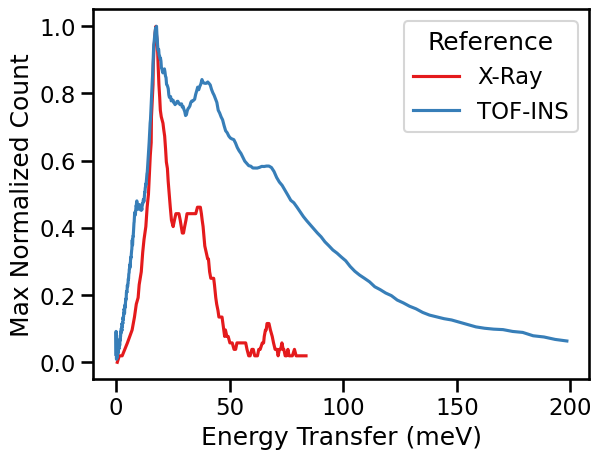

In [4]:

sns.lineplot(data=df_experiment
    , y='Max Normalized Count'
             , x='Energy Transfer (meV)'
             ,hue="Reference"
             ,palette='Set1'
            )


In [5]:
results_directory={"../results/lammps/bulk/lennard_jones/results/mdanse/":"LJ"
                   ,"../results/lammps/bulk/coulombic_buckingham/results/mdanse/":"CB"
                   ,"../results/lammps/bulk/reaxff2010_full/results/mdanse/":"ReaxFF 2010 full"
                   ,"../results/lammps/bulk/reaxff2010_ox/results/mdanse/":"ReaxFF 2010 ox"
                   ,"../results/lammps/bulk/reaxff2022/results/mdanse/":"ReaxFF 2022"
                   
                  }
df_list=list()

min_energy=0.25
max_energy=150

for data_directory,force_field in results_directory.items():
    for filename in os.listdir(data_directory):
        if not "dos.h5" in filename:
            continue
        df_tmp=read_lammps_dos(os.path.join(data_directory,filename),min_energy,max_energy)
        directory_split=data_directory.split("/")
        system=directory_split[3]
        df_tmp["Software"]=directory_split[2]
        df_tmp["System"]=system 
        label="%s lammps"%(system)
        df_tmp["Force Field"]=force_field
        df_tmp["Temperature (K)"]=int(filename.split("_")[2].replace('K',''))
        df_tmp["Weight"]=" ".join(filename.split("_")[:-2]).replace('b ','').capitalize()        
        df_list.append(df_tmp)
        
        print(os.path.join(data_directory,filename),force_field)

df_dos_lammps=pd.concat(df_list,ignore_index=True)
df_dos_lammps

../results/lammps/bulk/lennard_jones/results/mdanse/b_coherent_300K_dos.h5 LJ
../results/lammps/bulk/lennard_jones/results/mdanse/b_incoherent_300K_dos.h5 LJ
../results/lammps/bulk/coulombic_buckingham/results/mdanse/b_coherent_300K_dos.h5 CB
../results/lammps/bulk/coulombic_buckingham/results/mdanse/b_incoherent_300K_dos.h5 CB
../results/lammps/bulk/reaxff2010_full/results/mdanse/b_coherent_300K_dos.h5 ReaxFF 2010 full
../results/lammps/bulk/reaxff2010_full/results/mdanse/b_incoherent_300K_dos.h5 ReaxFF 2010 full
../results/lammps/bulk/reaxff2010_ox/results/mdanse/b_coherent_300K_dos.h5 ReaxFF 2010 ox
../results/lammps/bulk/reaxff2010_ox/results/mdanse/b_incoherent_300K_dos.h5 ReaxFF 2010 ox
../results/lammps/bulk/reaxff2022/results/mdanse/b_coherent_300K_dos.h5 ReaxFF 2022
../results/lammps/bulk/reaxff2022/results/mdanse/b_incoherent_300K_dos.h5 ReaxFF 2022


,dos Fe (nm2/ps),dos O (nm2/ps),dos total (nm2/ps),omega (rad/ps),omega window (au),time window (au),Energy Transfer (meV),Normalized Count,Fe,Max Normalized Fe,O,Max Normalized O,Max Normalized Count,Software,System,Force Field,Temperature (K),Weight
0,7.760039e-06,0.000019,1.292787e-05,0.439867,0.0,1.0,0.289520,0.538223,0.309203,0.029363,0.121382,0.053314,0.064792,lammps,bulk,LJ,300,Coherent
1,-7.711200e-06,-0.000019,-1.281158e-05,0.502705,0.0,1.0,0.330881,-0.205147,-0.118176,-0.011222,-0.046203,-0.020294,-0.024696,lammps,bulk,LJ,300,Coherent
2,7.754785e-06,0.000019,1.292027e-05,0.565543,0.0,1.0,0.372241,0.224128,0.128747,0.012226,0.050548,0.022202,0.026981,lammps,bulk,LJ,300,Coherent
3,-7.716003e-06,-0.000019,-1.281560e-05,0.628381,0.0,1.0,0.413601,-0.222312,-0.128104,-0.012165,-0.050062,-0.021988,-0.026762,lammps,bulk,LJ,300,Coherent
4,7.744900e-06,0.000019,1.290985e-05,0.691220,0.0,1.0,0.454961,0.223947,0.128583,0.012211,0.050519,0.022189,0.026959,lammps,bulk,LJ,300,Coherent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36195,7.893534e-08,0.000001,1.523481e-07,227.599737,0.0,1.0,149.806147,0.000293,0.000066,0.000005,0.000272,0.000064,0.000014,lammps,bulk,ReaxFF 2022,300,Incoherent
36196,-7.005700e-08,-0.000001,-1.257728e-07,227.662575,0.0,1.0,149.847507,0.000292,0.000066,0.000005,0.000272,0.000064,0.000013,lammps,bulk,ReaxFF 2022,300,Incoherent
36197,7.849491e-08,0.000001,1.476603e-07,227.725413,0.0,1.0,149.888867,0.000291,0.000066,0.000005,0.000271,0.000063,0.000013,lammps,bulk,ReaxFF 2022,300,Incoherent
36198,-6.862529e-08,-0.000001,-1.270337e-07,227.788251,0.0,1.0,149.930227,0.000290,0.000066,0.000005,0.000270,0.000063,0.000013,lammps,bulk,ReaxFF 2022,300,Incoherent


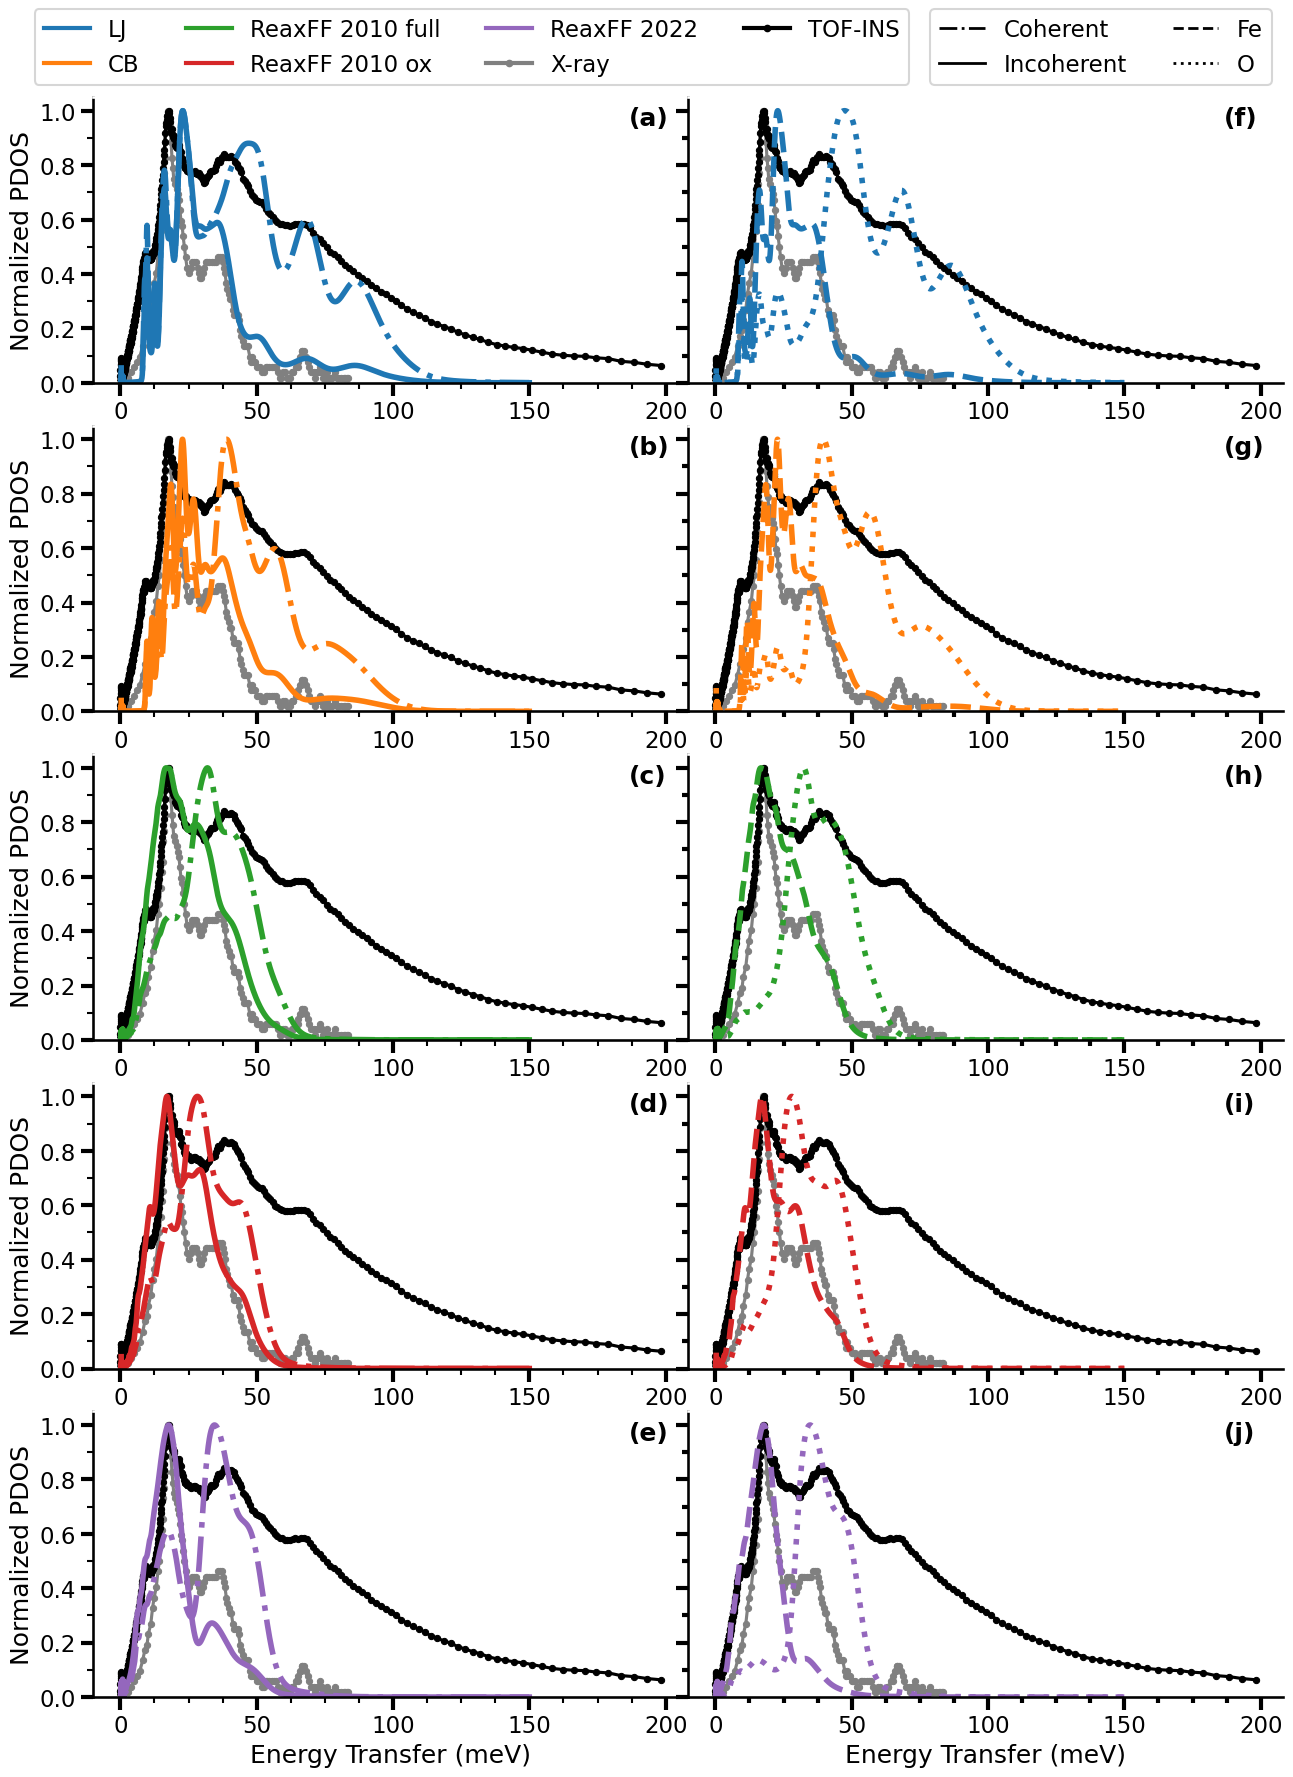

In [7]:

force_field=list(df_dos_lammps["Force Field"].unique())
palette=sns.color_palette("tab10")

fig, axs = plt.subplots(ncols=2,nrows=len(force_field),figsize=(7*2,4*len(force_field)))
sns.set_context("talk")

labx=0.9
laby=0.9
emin,emax=0.25,150
index=["(%s)"%x for x in list("afbgchdiej")]
for i,ff in enumerate(force_field):
    ax=axs[i,0]
    ax.text(labx, laby, index[2*i],weight='bold' ,transform=ax.transAxes)
        
    sns.lineplot(data=df_experiment.query(" Reference == 'X-Ray'")
                ,y='Max Normalized Count'
                ,x='Energy Transfer (meV)'
                ,ax=ax
               ,color="grey"
                 ,marker="."
                 ,markerfacecolor="grey"
                 , markeredgecolor="grey"
                )

    sns.lineplot(data=df_experiment.query(" Reference == 'TOF-INS'")
                ,y='Max Normalized Count'
                ,x='Energy Transfer (meV)'
                ,ax=ax
               ,color="black"
                ,marker="."
                 ,markerfacecolor="black"
                 , markeredgecolor="black"
           )

    sns.lineplot(data=df_dos_lammps.query(" %f < `Energy Transfer (meV)` and `Energy Transfer (meV)` < %f and Weight== 'Coherent' and `Force Field` == '%s' "%(emin,emax,ff))
                ,y='Max Normalized Count'
                ,x='Energy Transfer (meV)'
                ,ax=ax
               ,color=palette[i]
              ,linestyle='dashdot'
                ,linewidth=4
                )
    
    sns.lineplot(data=df_dos_lammps.query(" %f < `Energy Transfer (meV)` and `Energy Transfer (meV)` < %f and Weight== 'Incoherent' and `Force Field` == '%s' "%(emin,emax,ff))
                ,y='Max Normalized Count'
                ,x='Energy Transfer (meV)'
                ,ax=ax
               ,color=palette[i]
                ,linewidth=4

           )

    ax.spines['bottom'].set_color('0')
    ax.spines['top'].set_color('1')
    ax.spines['right'].set_color('1')
    ax.spines['left'].set_color('0')
    ax.tick_params(direction='out', width=3, bottom=True, left=True)
    ax.grid(False)

    ax.xaxis.set_minor_locator(MultipleLocator(25/2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.tick_params(which='minor', length=4)


    if i != len(force_field)-1:
        ax.set_xlabel("")
    ax.set_ylabel("Normalized PDOS")
    ax.set_ylim(-0.0,1.05)
    
    ########################## --- (b) --- ##########################
    ax=axs[i,1]
    ax.text(labx, laby, index[2*i+1],weight='bold' ,transform=ax.transAxes)
    
    sns.lineplot(data=df_experiment.query(" Reference == 'X-Ray'")
                ,y='Max Normalized Count'
                ,x='Energy Transfer (meV)'
                ,ax=ax
               ,color="grey"
                 ,marker="."
                 ,markerfacecolor="grey"
                 , markeredgecolor="grey"
     )
    
    sns.lineplot(data=df_experiment.query(" Reference == 'TOF-INS'")
                ,y='Max Normalized Count'
                ,x='Energy Transfer (meV)'
                ,ax=ax
               ,color="black"
                 ,marker="."
                 ,markerfacecolor="black"
                 , markeredgecolor="black"
           )

    
    sns.lineplot(data=df_dos_lammps.query(" %f < `Energy Transfer (meV)` and `Energy Transfer (meV)` < %f and Weight== 'Incoherent' and `Force Field` == '%s' "%(emin,emax,ff))
                ,y='Max Normalized Fe'
                ,x='Energy Transfer (meV)'
                ,ax=ax
               ,color=palette[i]
                ,linestyle='dashed'
                ,linewidth=4
           )
    sns.lineplot(data=df_dos_lammps.query(" %f < `Energy Transfer (meV)` and `Energy Transfer (meV)` < %f and Weight== 'Incoherent' and `Force Field` == '%s' "%(emin,emax,ff))
                ,y='Max Normalized O'
                ,x='Energy Transfer (meV)'
                ,ax=ax
               ,color=palette[i]
               , linestyle='dotted'
                ,linewidth=4
           )

    ax.spines['bottom'].set_color('0')
    ax.spines['top'].set_color('1')
    ax.spines['right'].set_color('1')
    ax.spines['left'].set_color('0')
    ax.tick_params(direction='out', width=3, bottom=True, left=True)
    ax.grid(False)
    ax.xaxis.set_minor_locator(MultipleLocator(25/2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.tick_params(which='minor', length=4, width=3)


    if i != len(force_field)-1:
        ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_yticklabels([])
    ax.set_ylim(-0.0,1.05)


    if i==0:
        custom_lines = [Line2D([0], [0], color=palette[i], lw=3) for i,v in enumerate(force_field)]+[Line2D([0], [0], color="grey", lw=3, marker=".")]+[Line2D([0], [0], color="black", lw=3, marker=".")]
        ax.legend(custom_lines,force_field+["X-ray","TOF-INS"])
        sns.move_legend(ax,'center left',bbox_to_anchor=(0.05,0.925),ncol=4,bbox_transform=fig.transFigure)

custom_lines = [Line2D([0], [0], color="black", lw=2,linestyle="dashdot")
                ,Line2D([0], [0], color="black", lw=2)
                ,Line2D([0], [0], color="black", lw=2,linestyle="dashed")
                ,Line2D([0], [0], color="black", lw=2,linestyle="dotted")]
ax.legend(custom_lines,["Coherent","Incoherent","Fe","O"])
sns.move_legend(ax,'center right',bbox_to_anchor=(0.95,0.925),ncol=2,bbox_transform=fig.transFigure)


# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.95, 
                    top=0.9, 
                    wspace=0, 
                    hspace=0.15
                   )

plt.savefig("../figures/fig1.pdf", pad_inches=0.2,bbox_inches="tight")